# IC3D generated image error analysis

## Load and transform data

In [1]:
library(tidyverse)
library(broom)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
# this csv file is all cells, with 1000 latent space samples per cell

csv_file = "all_dat.csv"
df = read_csv(csv_file)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  data_provider_index = col_integer(),
  img_index = col_integer(),
  label = col_character(),
  log_det = col_double(),
  log_det_scaled = col_double(),
  path = col_character(),
  train_or_test = col_character()
)


In [3]:
# remove rows with missing data
df = df[complete.cases(df), ]

# remove empty cols
drop_cols = c("X1", "Unnamed: 0")
df = select(df,-one_of(drop_cols))

Warning message:
"Unknown variables: `Unnamed: 0`"

In [4]:
df %>% glimpse

Observations: 21,967
Variables: 7
$ data_provider_index <int> 8213, 18120, 5167, 739, 9288, 7321, 5916, 4827,...
$ img_index           <int> 9123, 20150, 5759, 7251, 10321, 8128, 6591, 538...
$ label               <chr> "Lamin B1", "Tom20", "Lamin B1", "Lamin B1", "S...
$ log_det             <dbl> -5677.829, -4749.293, -5986.030, -5669.664, -35...
$ log_det_scaled      <dbl> -5.677829, -4.749293, -5.986030, -5.669664, -3....
$ path                <chr> "3500000958_10X_20170606_4-Scene-07-P34-E07.czi...
$ train_or_test       <chr> "train", "train", "train", "test", "train", "tr...


In [5]:
# change data types of some cols
df %>%
    mutate(
        train_or_test=as.factor(train_or_test),
        label=as.factor(label)
    ) -> df

## Join in mitotic annotations

In [17]:
df_mito = read_csv("/root/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31/data_jobs_out_mitotic_annotations.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  outputThisCellIndex = col_double(),
  MitosisLabel = col_double(),
  FinalScore = col_integer(),
  Index = col_double(),
  SegmentationXyPixelSize = col_double(),
  SegmentationZPixelSize = col_double(),
  Version = col_double(),
  imageXyPixelSize = col_double(),
  imageZPixelSize = col_double(),
  lightChannel = col_double(),
  memChannel = col_double(),
  nucChannel = col_double(),
  structureChannel = col_double(),
  timePoint = col_double()
)
See spec(...) for full column specifications.


In [18]:
df_mito %>%
    rowwise() %>%
    mutate(path = paste(inputFilename,outputThisCellIndex,sep='_')) %>%
    select(path, MitosisLabel) ->
    df_mito

df_mito %>% 
    left_join(df) ->
    df

df$MitosisLabel = as.factor(df$MitosisLabel)

df %>% write_csv('df_alldat_mito.csv')

Joining, by = c("path", "MitosisLabel")


## Plots

### test vs train metrics

#### pearson correlation

Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."Warning message:
"Removed 1 rows containing non-finite values (stat_density)."

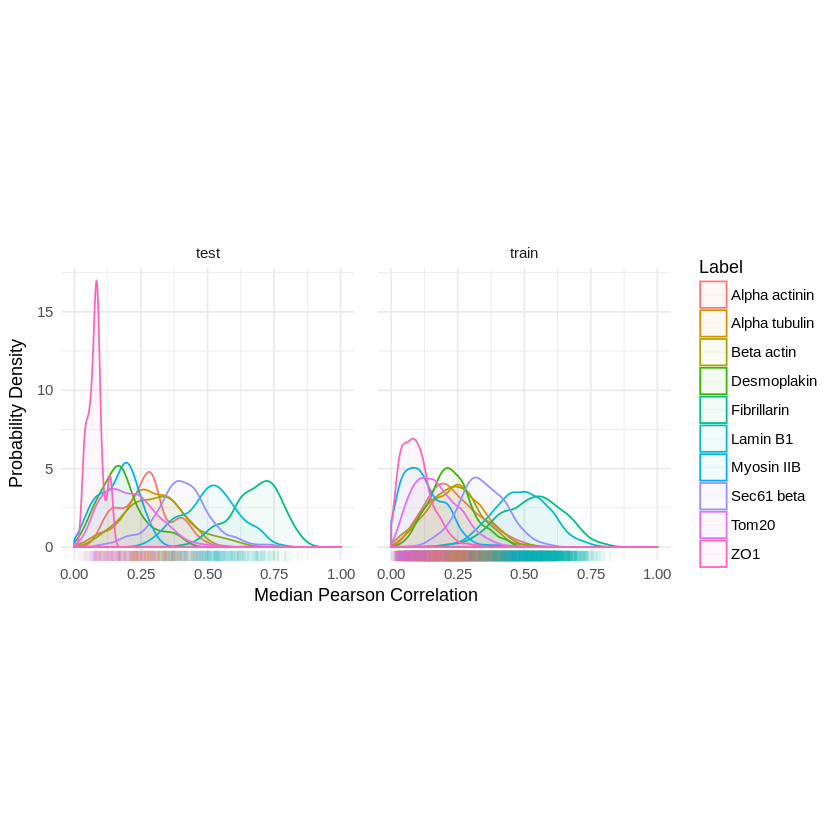

In [23]:
df_stats %>%
    ggplot(aes(x=pearson_recon_median, color=img_label, fill=img_label)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    xlim(c(0,1)) +
    facet_wrap(~img_phase, scales = 'fixed') +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
    labs(x="Median Pearson Correlation", y= "Probability Density", color="Label", fill="Label") ->
    p

ggsave(p, filename = "pearson_by_class.png", device="png", dpi = 600)
p

### mitotic vs non-mitotic metrics

#### pearson correlation

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."

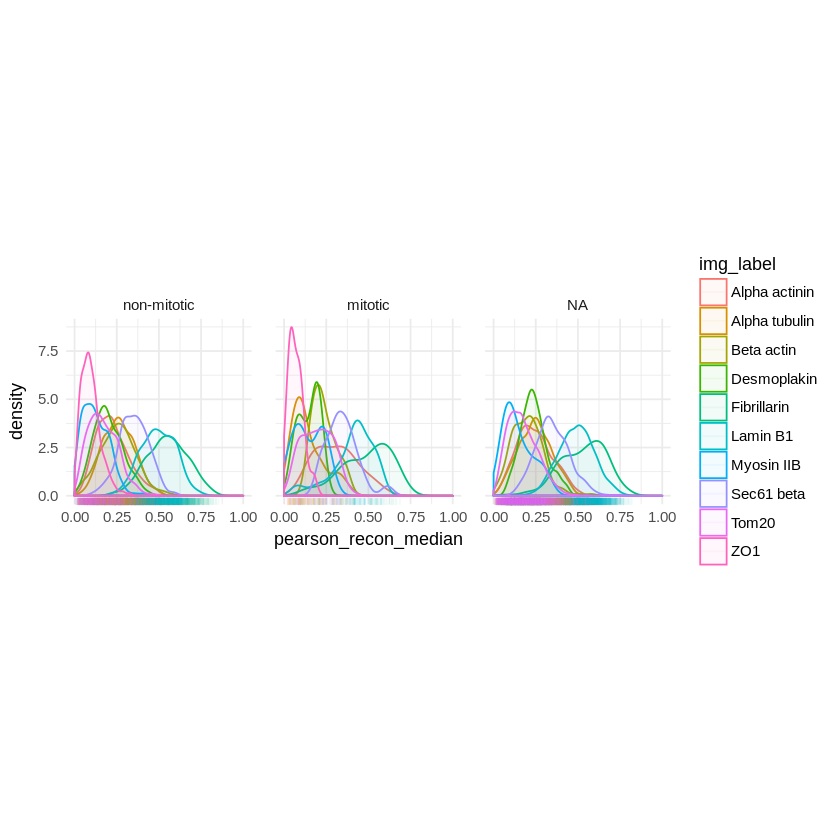

In [57]:
df_stats_mito %>%
    ggplot(aes(x=pearson_recon_median, color=img_label, fill=img_label)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    xlim(c(0,1)) +
    facet_wrap(~BinaryMitosisLabel, scales = 'fixed') +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines"))

Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."Warning message:
"Removed 1 rows containing non-finite values (stat_density)."

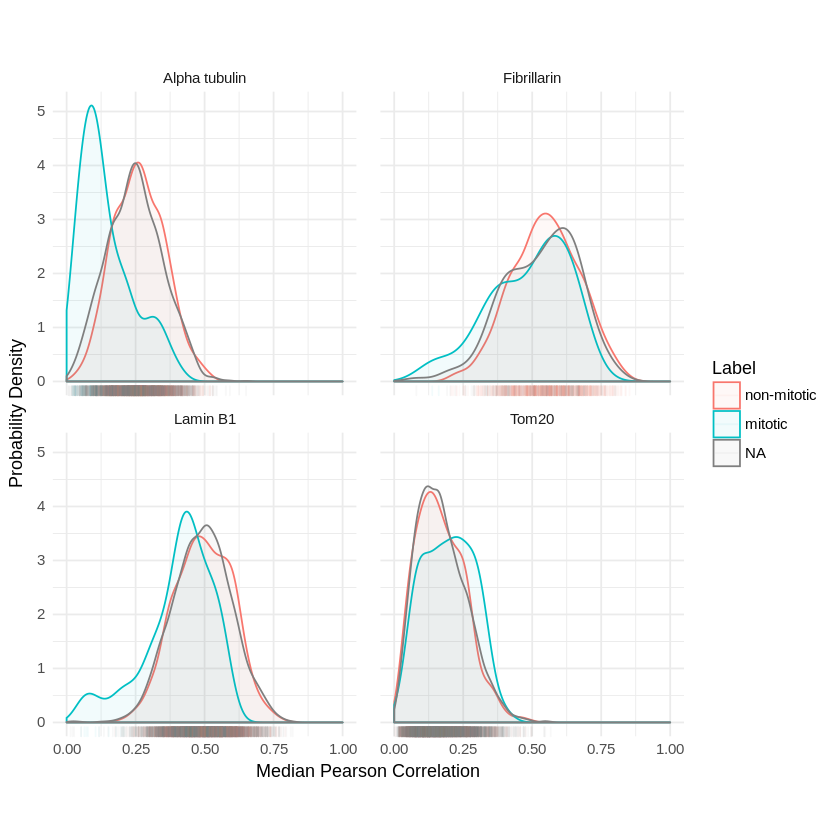

In [64]:
df_stats_mito %>%
    filter(img_label %in% c('Lamin B1', 'Alpha tubulin', 'Tom20', 'Fibrillarin')) ->
    df_stats_mito_filtered

df_stats_mito_filtered %>%
    ggplot(aes(x=pearson_recon_median, color=BinaryMitosisLabel, fill=BinaryMitosisLabel)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    xlim(c(0,1)) +
    facet_wrap(~img_label, scales = 'fixed', ncol=2) +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
    labs(x="Median Pearson Correlation", y= "Probability Density", color="Label", fill="Label") ->
    p

ggsave(p, filename = "pearson_by_mito_3.png", device="png", dpi = 600)
p

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."

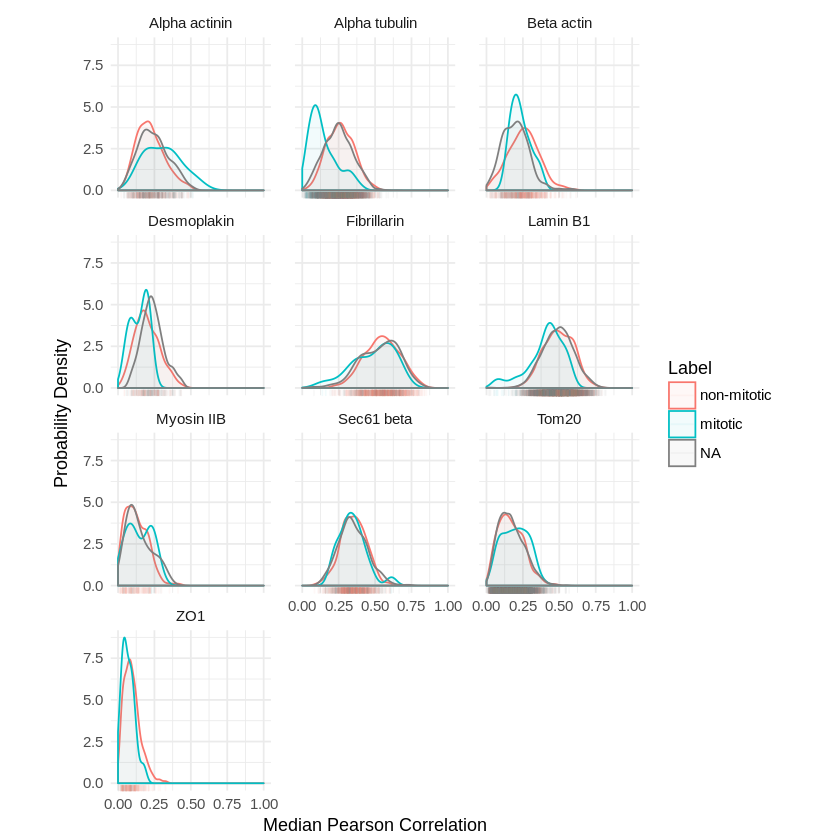

In [92]:
df_stats_mito %>%
    ggplot(aes(x=pearson_recon_median, color=BinaryMitosisLabel, fill=BinaryMitosisLabel)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    xlim(c(0,1)) +
    facet_wrap(~img_label, scales = 'fixed', ncol=3) +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
    labs(x="Median Pearson Correlation", y= "Probability Density", color="Label", fill="Label") ->
    p

# ggsave(p, filename = "pearson_by_mito_3.png", device="png", dpi = 600)
p

In [78]:
# pval_df = tibble(label = character(0), pvalue = numeric(0))

for (label in levels(df_stats_mito$img_label)) {

    df_stats_mito %>%
        filter(img_label == label) %>%
        select(BinaryMitosisLabel, pearson_recon_median) ->
        df_tmp

    df_tmp %>%
        filter(BinaryMitosisLabel == "mitotic") %>%
        select(pearson_recon_median) ->
        df_x

    df_tmp %>%
        filter(BinaryMitosisLabel != "mitotic") %>%
        select(pearson_recon_median) ->
        df_y

    test_output = ks.test(df_x$pearson_recon_median, df_y$pearson_recon_median)
    print(paste(label, ':',  test_output$p.value))
    
#     df_singlep = tibble(label = label, pvalue = test_output$p.value), )
#     pval_df = rbind(pval_df, c(label,test_output$p.value))
}

[1] "Alpha actinin : 0.0958804732013879"
[1] "Alpha tubulin : 0"
[1] "Beta actin : 0.251916171850633"
[1] "Desmoplakin : 0.0973235979686922"
[1] "Fibrillarin : 0.039849526190801"


Warning message in ks.test(df_x$pearson_recon_median, df_y$pearson_recon_median):
"p-value will be approximate in the presence of ties"

[1] "Lamin B1 : 3.62340997206445e-08"
[1] "Myosin IIB : 0.369553074735627"


Warning message in ks.test(df_x$pearson_recon_median, df_y$pearson_recon_median):
"p-value will be approximate in the presence of ties"

[1] "Sec61 beta : 0.761425762073476"
[1] "Tom20 : 0.0690946017511099"
[1] "ZO1 : 0.200627431636893"


## Save out best and worst predictions

In [116]:
df_key = df %>% distinct(img_index,img_dp_index,img_phase,img_label,img_path)
df_key %>% write_csv("df_key.csv")

### use cells that aren't annotated

In [117]:
# Can't sample too many or we run out of samples for the poorly sampled classes
N=8

# sort by best and worst
df_stats_mito %>%
    select(img_index, img_label, img_phase, pearson_recon_median, BinaryMitosisLabel) %>%
    group_by(img_label, img_phase) %>%
    top_n(N, pearson_recon_median) ->
    df_best_preds
df_stats_mito %>%
    select(img_index, img_label, img_phase, pearson_recon_median, BinaryMitosisLabel) %>%
    group_by(img_label, img_phase) %>%
    top_n(N, desc(pearson_recon_median)) ->
    df_worst_preds

# join in dp / master index key
df_key %>%
    inner_join(df_best_preds) -> df_best_preds
df_key %>%
    inner_join(df_worst_preds) -> df_worst_preds

# label and combine
df_best_preds$Type = "best"
df_worst_preds$Type = "worst"
df_extremal_preds = rbind(df_best_preds, df_worst_preds)

# write out
df_best_preds %>% write_csv("best_preds.csv")
df_worst_preds %>% write_csv("worst_preds.csv")
df_extremal_preds %>% write_csv("extremal_preds.csv")

Warning message:
"Grouping rowwise data frame strips rowwise nature"Warning message:
"Grouping rowwise data frame strips rowwise nature"Joining, by = c("img_index", "img_phase", "img_label")
Joining, by = c("img_index", "img_phase", "img_label")


### use only annotated cells

In [118]:
# Can't sample too many or we run out of samples for the poorly sampled classes
N=8

# sort by best and worst
df_stats_mito %>%
    filter(!is.na(MitosisLabel)) %>%
    select(img_index, img_label, img_phase, pearson_recon_median, BinaryMitosisLabel) %>%
    group_by(img_label, img_phase) %>%
    top_n(N, pearson_recon_median) ->
    df_best_preds
df_stats_mito %>%
    filter(!is.na(MitosisLabel)) %>%
    select(img_index, img_label, img_phase, pearson_recon_median, BinaryMitosisLabel) %>%
    group_by(img_label, img_phase) %>%
    top_n(N, desc(pearson_recon_median)) ->
    df_worst_preds

# join in dp / master index key
df_key %>%
    inner_join(df_best_preds) -> df_best_preds
df_key %>%
    inner_join(df_worst_preds) -> df_worst_preds

# label and combine
df_best_preds$Type = "best"
df_worst_preds$Type = "worst"
df_extremal_preds = rbind(df_best_preds, df_worst_preds)

# write out
df_best_preds %>% write_csv("best_preds_annotated_only.csv")
df_worst_preds %>% write_csv("worst_preds_annotated_only.csv")
df_extremal_preds %>% write_csv("extremal_preds_annotated_only.csv")

Warning message:
"Grouping rowwise data frame strips rowwise nature"Warning message:
"Grouping rowwise data frame strips rowwise nature"Joining, by = c("img_index", "img_phase", "img_label")
Joining, by = c("img_index", "img_phase", "img_label")


## chi-squared test for good vs bad mitotic enrichment

In [119]:
# split by test / train 

df_extremal_preds$Type = as.factor(df_extremal_preds$Type)

df_pval = data.frame()
for (label in levels(df_extremal_preds$img_label)) {

    df_extremal_preds %>%
        filter(img_label == label) %>%
        select(BinaryMitosisLabel, Type) ->
        df_extremal_preds_tmp

    df_extremal_preds_tmp %>%
        filter(Type=='best') ->
        df_best_tmp
    
    df_extremal_preds_tmp %>%
        filter(Type=='worst') ->
        df_worst_tmp
    
    test_out = chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel,
                          df_extremal_preds_tmp$Type, correct=FALSE) %>%
                          tidy
    
    test_out$label = label
    df_pval = rbind(df_pval,test_out)
    
}

df_pval$p.value.bonf = df_pval$p.value*nrow(df_pval)

Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approxima

In [120]:
df_pval %>%
    arrange(p.value.bonf)

statistic,p.value,parameter,method,label,p.value.bonf
16.761905,4.237556e-05,1,Pearson's Chi-squared test,Alpha tubulin,4.237556e-04
14.545455,1.368183e-04,1,Pearson's Chi-squared test,Lamin B1,1.368183e-03
3.310345,6.884504e-02,1,Pearson's Chi-squared test,Desmoplakin,6.884504e-01
2.133333,1.441270e-01,1,Pearson's Chi-squared test,Fibrillarin,1.441270e+00
2.133333,1.441270e-01,1,Pearson's Chi-squared test,ZO1,1.441270e+00
1.032258,3.096289e-01,1,Pearson's Chi-squared test,Beta actin,3.096289e+00
1.032258,3.096289e-01,1,Pearson's Chi-squared test,Myosin IIB,3.096289e+00
1.032258,3.096289e-01,1,Pearson's Chi-squared test,Tom20,3.096289e+00
0.000000,1.000000e+00,1,Pearson's Chi-squared test,Alpha actinin,1.000000e+01
0.000000,1.000000e+00,1,Pearson's Chi-squared test,Sec61 beta,1.000000e+01


### weird pearson vs MSE plot

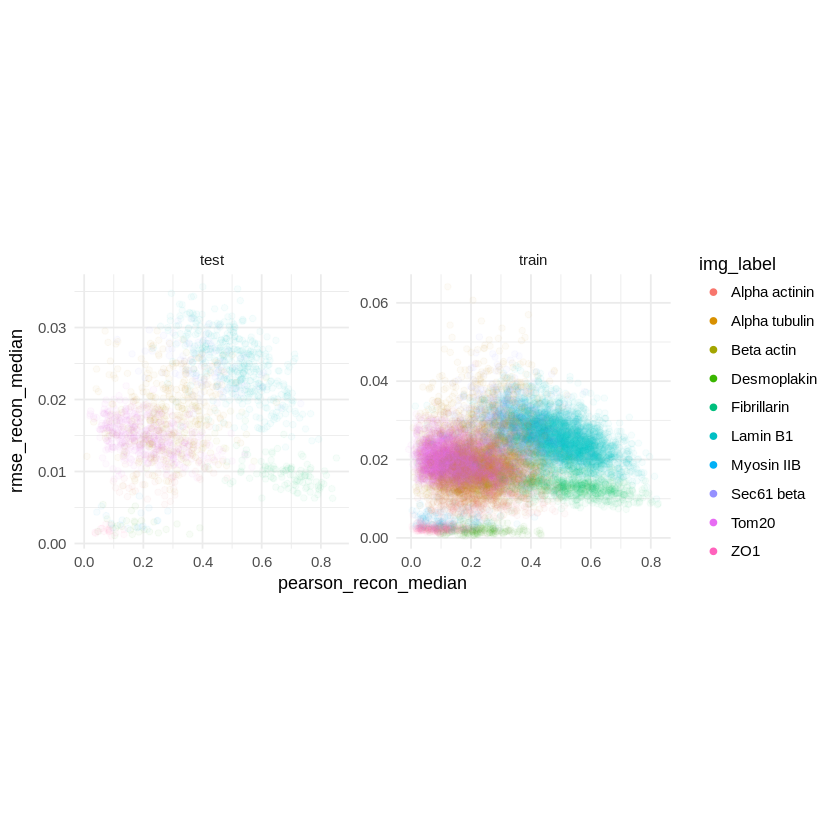

In [103]:
df_stats %>%
    ggplot(aes(x=pearson_recon_median, y=rmse_recon_median, color=img_label, fill=img_label)) +
        geom_point(alpha=0.03) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

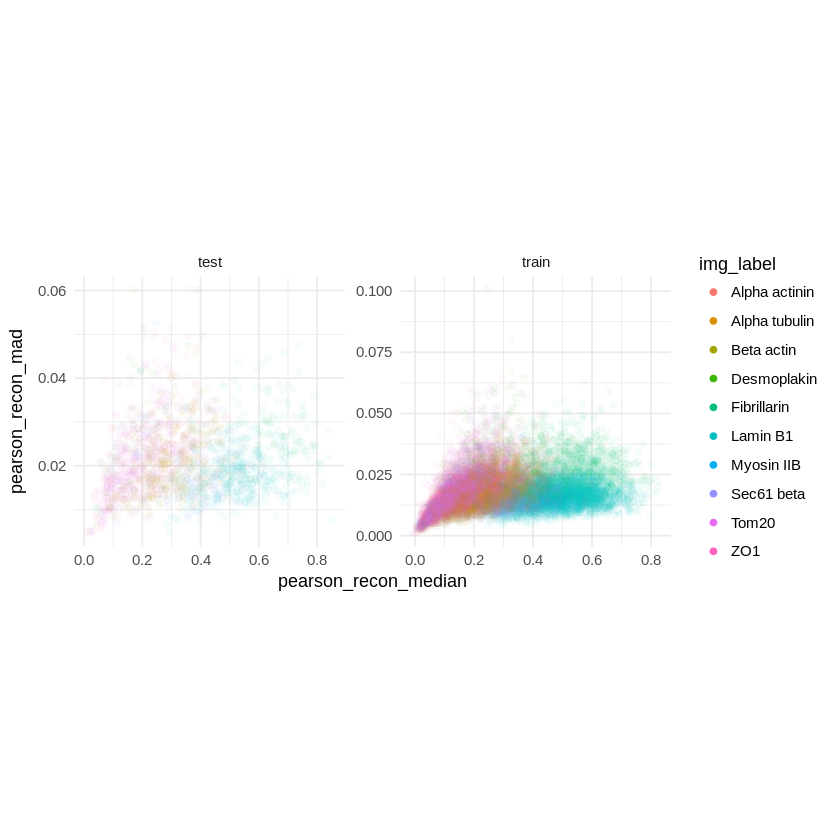

In [82]:
df_stats %>%
    ggplot(aes(x=pearson_recon_median, y=pearson_recon_mad, color=img_label, fill=img_label)) +
        geom_point(alpha=0.03) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

## check recon vs orig

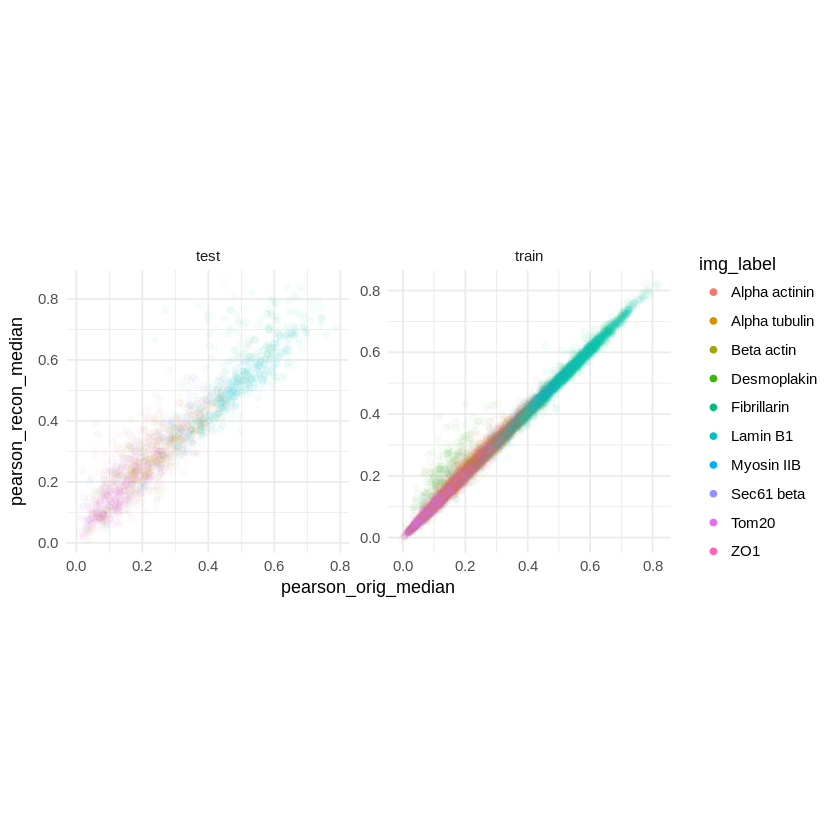

In [80]:
df_stats %>%
    ggplot(aes(x=pearson_orig_median, y=pearson_recon_median, color=img_label, fill=img_label)) +
        geom_point(alpha=0.03) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))